# **Set up Environment**
---

1. Open file on Google Colab
2. Create a shortcut on the drive from https://drive.google.com/drive/folders/1pCEBqzQDTJ3PlgdIRBY65jOugJ4xpFi6?usp=sharing
3. Edit all file paths (marked with ## CHANGE ##) to fit ur  project environment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# pull git
%cd /content
!git clone https://github.com/hmanhduc2k/CS4243-Mini-Project # version with only 800 data
# !git clone https://github.com/wilfredbtan/CS4243-Mini-Project # Uncomment this to clone it once
%cd /content/CS4243-Mini-Project
!git pull
!git checkout main
!ls

/content
Cloning into 'CS4243-Mini-Project'...
remote: Enumerating objects: 5034, done.
remote: Counting objects: 100% (1584/1584), done.
remote: Compressing objects: 100% (1569/1569), done.
remote: Total 5034 (delta 20), reused 1575 (delta 15), pack-reused 3450
Receiving objects: 100% (5034/5034), 4.79 GiB | 16.51 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/CS4243-Mini-Project
Already up to date.
Already on 'main'
Your branch is up to date with 'origin/main'.
CS4243_MiniProject.ipynb  README.md	     test_out.pth
dataset.csv		  requirements.txt   train_label.csv
initData.sh		  splitTrainTest.sh  WeaponDetection.pth
model1.pth		  template.py
model_template.ipynb	  test_label.csv


In [5]:
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 33.3 MB/s 
     |████████████████████████████████| 163 kB 68.1 MB/s 
     |████████████████████████████████| 7.6 MB 53.7 MB/s 


In [6]:
# gets train test split
## COMMENT OUT AFTER RUNNING ONCE ##
# %%bash
# chmod +x /content/CS4243-Mini-Project/initData.sh
# /content/CS4243-Mini-Project/initData.sh
# chmod +x /content/CS4243-Mini-Project/splitTrainTest.sh
# /content/CS4243-Mini-Project/splitTrainTest.sh

Import packages:

In [7]:
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import torch
import torchvision
from torchvision.transforms import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

from PIL import Image
torch.manual_seed(42)

import torch.optim as optim
from torch.optim import Adam

from transformers import T5ForConditionalGeneration, AutoTokenizer, Adafactor

# **Data Visualization and Data Preparation**

---



Distribution of dataset:

In [8]:
# Split dataset into test and train

# dataset_size = len(train_dataset)
# train_size = int(0.8 * dataset_size)
# test_size = dataset_size - train_size

In [9]:
train_df = pd.read_csv("train_label.csv")
test_df = pd.read_csv("test_label.csv")
count = len(train_df)
normal_count = len(train_df[train_df["label"] == 0])
carrying_count = len(train_df[train_df["label"] == 1])
threat_count = len(train_df[train_df["label"] == 2])
print(f'TRAIN: Count: {count} - Normal: {normal_count*100/count:.2f}% - Carrying: {carrying_count*100/count:.2f}% - Threat: {threat_count*100/count:.2f}%')

count = len(test_df)
normal_count = len(test_df[test_df["label"] == 0])
carrying_count = len(test_df[test_df["label"] == 1])
threat_count = len(test_df[test_df["label"] == 2])
print(f'TEST: Count: {count} - Normal: {normal_count*100/count:.2f}% - Carrying: {carrying_count*100/count:.2f}% - Threat: {threat_count*100/count:.2f}%')

train_df.head()

TRAIN: Count: 739 - Normal: 54.80% - Carrying: 29.63% - Threat: 15.56%
TEST: Count: 85 - Normal: 52.94% - Carrying: 30.59% - Threat: 16.47%


directory  label
0  normal/00000.42797_100.png      0
1  normal/00000.42797_200.png      0
2   normal/00000.42797_30.png      0
3  normal/00010.40911_100.png      0
4   normal/00010.40911_30.png      0

In [10]:
%cd /content/drive/My Drive/cs4243 test

/content/drive/My Drive/cs4243 test


Preparing datapaths:

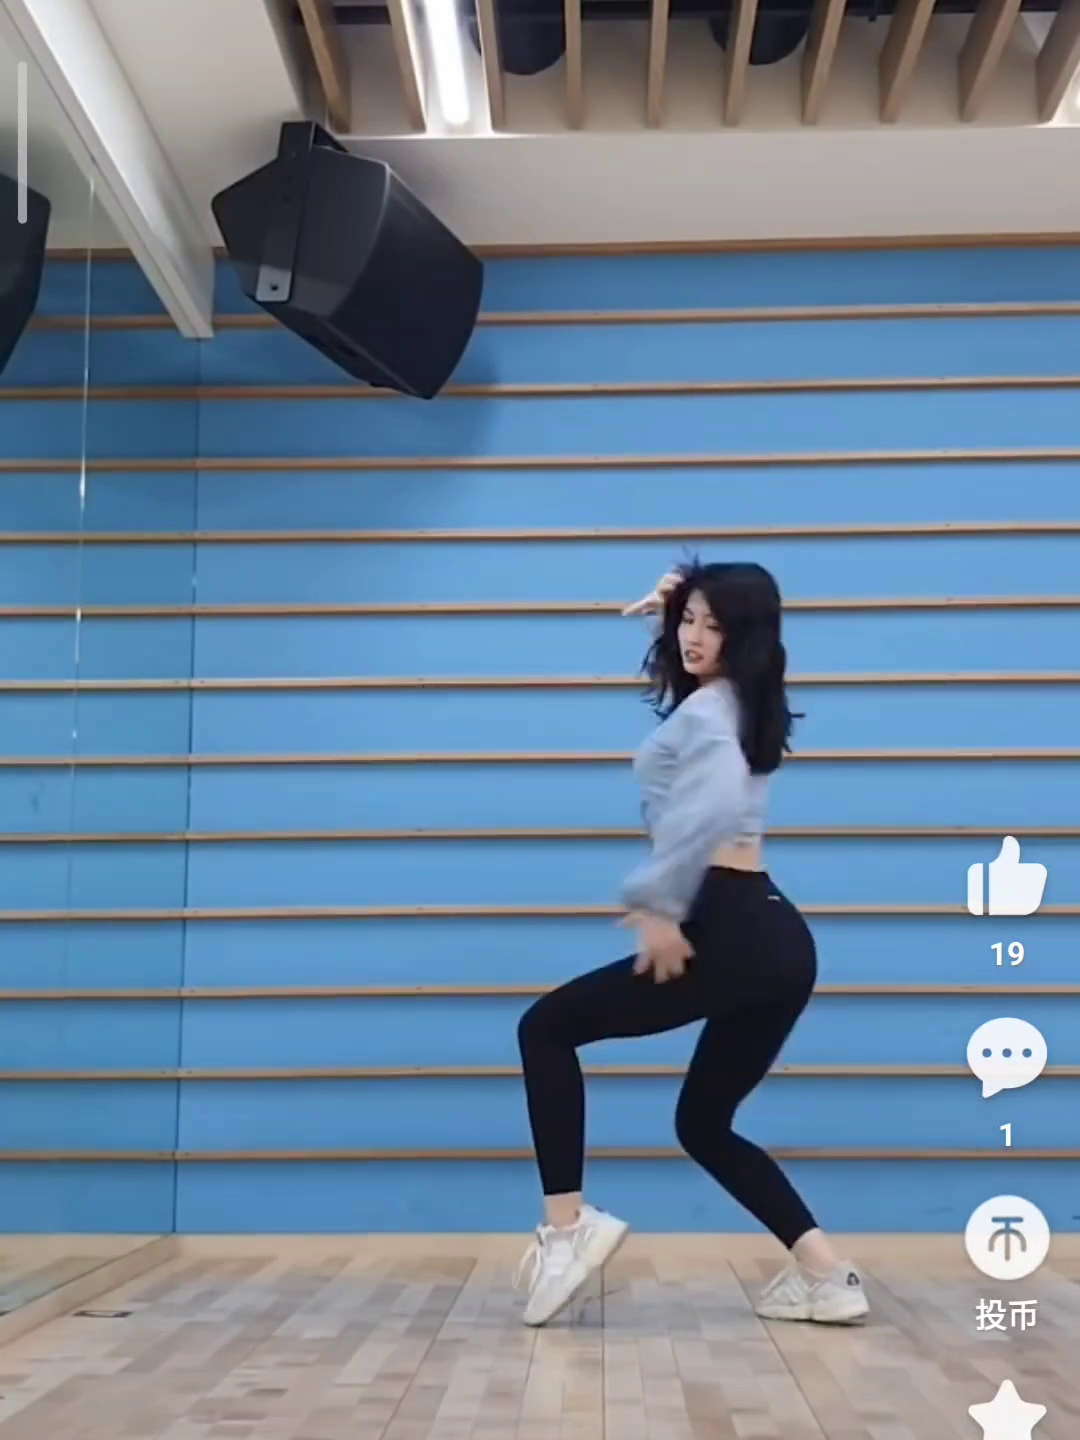

In [11]:
root = "./cs4243_smallest/" ## CHANGE ##
# root = "./cs4243_smallest/" # on local machine
img_path = train_df['directory'][0]

img = Image.open(root + str(img_path)) #similar to cv2.imread()
img

# Data Loader

---

In [12]:
class CS4243_dataset(Dataset): 
    def __init__(self, root_path , dataframe, transform=None):
        self.df = dataframe    
        self.transform = transform
        self.root_path = root_path
        
        self.image_paths = self.df['directory']
        self.labels = self.df['label']
                
    def __getitem__(self, index):
        img_path = self.image_paths[index] 
        image = Image.open(self.root_path + str(img_path))
        target = torch.tensor(self.labels[index])
      
        if self.transform != None:
            image = self.transform(image)
          
        return [image, target, img_path]
       
    def __len__(self):
        return len(self.df)

# **Neural Networks**
---

### **NETWORK 1**
2 Layers of CNN, max pooled, 2 layers of dense linear, no need for transform resize due to adaptive max pool

In [ ]:
class Network1(nn.Module):
    def __init__(self, number_of_labels, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 12, 5),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(12, 16, 5),
                                nn.ReLU(),
                                nn.AdaptiveMaxPool2d((5, 5))) # can also use transformer instead to standardize input size
        self.fc1 = nn.Sequential(nn.Flatten(),
                                nn.Dropout(p=dropout),
                                nn.Linear(16 * 5 * 5, 120),
                                nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84),
                                nn.ReLU())
        self.fc3 = nn.Linear(84, number_of_labels)

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.fc1(h2)
        h4 = self.fc2(h3)
        y = self.fc3(h4)
        return y

### **NETWORK 2**

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, number_of_labels, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 12, 5),
                                   nn.BatchNorm2d(12),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(12, 12, 5),
                                   nn.BatchNorm2d(12),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(nn.Conv2d(12, 24, 5),
                                   nn.BatchNorm2d(24),
                                   nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(24, 24, 3),
                                   nn.BatchNorm2d(24),
                                   nn.ReLU())
        self.conv5 = nn.Sequential(nn.Conv2d(24, 24, 3),
                                   nn.ReLU(),
                                   nn.AdaptiveMaxPool2d((3, 3)))
        self.fc1 = nn.Sequential(nn.Flatten(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(24 * 3 * 3, 120),
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 120),
                                 nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(120, 84),
                                 nn.ReLU())
        self.fc4 = nn.Linear(84, number_of_labels)

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.conv3(h2)
        h4 = self.conv4(h3)
        h5 = self.conv5(h4)
        h6 = self.fc1(h5)
        h7 = self.fc2(h6)
        h8 = self.fc3(h7)
        y = self.fc4(h8)
        return y

## **NETWORK 3**

In [98]:
class Network3(nn.Module):
    def __init__(self, number_of_labels, dropout=0.3):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(3, 12, 5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(12, 16, 5),
                                   nn.ReLU(),
                                   nn.AdaptiveMaxPool2d((5, 5))) # can also use transformer instead to standardize input size
        self.fc1 = nn.Sequential(nn.Flatten(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(16 * 5 * 5, 120),
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84),
                                 nn.ReLU())
        self.fc3 = nn.Linear(84, number_of_labels)

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.fc1(h2)
        h4 = self.fc2(h3)
        y = self.fc3(h4)
        return y

## **NETWORK 4**

In [13]:
class Network4(nn.Module):
    def __init__(self, number_of_labels, dropout=0.3):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(12, 12, 5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(12, 16, 5),
                                   nn.ReLU(),
                                   nn.AdaptiveMaxPool2d((5, 5))) # can also use transformer instead to standardize input size
        self.fc1 = nn.Sequential(nn.Flatten(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(16 * 5 * 5, 120),
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84),
                                 nn.ReLU())
        self.fc3 = nn.Linear(84, number_of_labels)

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.fc1(h2)
        h4 = self.fc2(h3)
        y = self.fc3(h4)
        return y

# **Training Function**
---

In [14]:
def train(model, data_loader, loss_fn, optimizer, num_epoch, device='cpu', model_path=None):
    start = datetime.datetime.now()
    losses = []

    for epoch in range(num_epoch):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0

        for i, (images, labels, _) in enumerate(data_loader, 0):
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 10 == 9:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        losses.append(running_loss)

    end = datetime.datetime.now()
    print('Training finished in {} minutes.'.format((end - start).seconds / 60.0)) 
        
    if model_path != None:
        torch.save(model.state_dict(), model_path)
        print('Model saved in ', model_path)
    
    print(losses)
    return model, losses

# **Testing Function**
---

In [15]:
def test(model, data_loader, output_path, device='cpu', classes=None):
    model.eval()

    with open(output_path, 'w+') as f_output:
            with torch.no_grad():
                for (images, labels, image_paths) in data_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    # the label with the highest energy will be our prediction
                    _, predicted = torch.max(outputs.data, 1)
                    for i in range(len(images)):
                        label_i = labels[i].item()
                        predicted_i = predicted[i].item()
                        image_path_i = image_paths[i]
                        if classes != None:
                            label_i = classes[label_i]
                            predicted_i = classes[predicted_i]
                        f_output.write("{0}, {1}, {2}\n".format(label_i, predicted_i, image_path_i))

    # compute the accuracy over all test images
    print("Testing finished. Model saved in ", output_path)

In [49]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Evaluate output file
def show_test_accuracy(output_path, root="", transformer=None, show=0):
    correct = defaultdict(int)
    count = defaultdict(int)
    images = []
    show_target = []
    show_predicted = []

    with open(output_path) as f:
        lines = f.read().splitlines()
        for line in lines:
            target, predicted, image_path = line.split(", ")
            count[target] += 1
            if target == predicted:
                correct[target] += 1
            if len(images) < show:
                image = Image.open(root + str(image_path))
                if transformer != None:
                    image = transformer(image)
                        
                images.append(image[:3, : ,:])
                show_target.append(target)
                show_predicted.append(predicted)
    
    total = [0, 0]
    for label in count:
        print("{0} accuracy: {1}/{2} = {3:.2f}%".format(label, correct[label], count[label], correct[label]/count[label]*100))
        total[1] += count[label]
        total[0] += correct[label]
    print("Overall accuracy: {0}/{1} = {2:.2f}%".format(total[0], total[1], total[0]/total[1]*100))
    
    if len(images) > 0:
        imageshow(torchvision.utils.make_grid(images))
        print("target: ", show_target)
        print("predicted: ", show_predicted)

In [17]:
def plotConfusionMatrix(output_path, classes):
    data = pd.read_csv(output_path, header=None, skipinitialspace=True)
    data = data.values
    target = data[:, 0]
    predicted = data[:, 1]
    cm = confusion_matrix(target, predicted, labels=classes)
    df_cm = pd.DataFrame(cm, index = [i for i in classes],
                    columns = [i for i in classes])
    plt.figure(figsize = (5, 4))
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Target")
    plt.show()
    return cm

def generateClassificationReport(output_path, classes):
    data = pd.read_csv(output_path, header=None, skipinitialspace=True)
    data = data.values
    target = data[:, 0]
    predicted = data[:, 1]
    print(classification_report(target, predicted, target_names=classes))

def plotROC(output_path, classes):
    data = pd.read_csv(output_path, header=None, skipinitialspace=True)
    data = data.values
    target = data[:, 0]
    predicted = data[:, 1]
    target = label_binarize(target, classes=classes)
    predicted = label_binarize(predicted, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(target[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(target.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot of a ROC curve for a specific class
    for i in range(len(classes)):
        plt.figure()
        lw = 2
        plt.plot(fpr[i], tpr[i], color='darkorange',
                lw=lw, label='ROC curve for %s (area = %0.2f)' % (classes[i], roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

# **Evaluation**

---


Normalize data using transformers:

In [ ]:
transformations = transforms.Compose([
    transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Dividing into batches:

In [ ]:
batch_size = 20
classes = ('normal', 'carrying', 'threat')
num_of_labels = len(classes)

# normalize data using transformers
transformations = transforms.Compose([
    transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train
train_set = CS4243_dataset(root, train_df, transform = transformations)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True, drop_last=True)
print("The number of images in a training set is: ", len(train_loader)*batch_size)

# test
test_set = CS4243_dataset(root, test_df, transform=transformations)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
print("The number of images in a test set is: ", len(test_loader)*batch_size)

print("The number of batches per epoch is: ", len(train_loader))

Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer:

In [ ]:
loss_fn = nn.CrossEntropyLoss
optimizer = Adam
optim_params = {'lr':0.001, 'weight_decay':0.0001}
epoch = 5
dropout = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

### **NETWORK 1**

In [ ]:
model1_path = "./model1.pth" ## CHANGE ##
output1_path = "./test_out1.pth" ## CHANGE ##

In [ ]:
model1 = Network1(num_of_labels, dropout).to(device)
_, losses1 = train(model1, train_loader, loss_fn(), 
                   optimizer(model1.parameters(), **optim_params), epoch, device, model1_path)
plt.plot(list(range(1, epoch + 1)), losses1, label='Training loss')
plt.legend()
plt.show()

In [ ]:
test(model1, test_loader, output1_path, device, classes)
show_test_accuracy(output1_path, root, transformations, show=10)

In [ ]:
cm1 = plotConfusionMatrix(output1_path, classes)

In [ ]:
generateClassificationReport(output1_path, classes)

In [ ]:
plotROC(output1_path, classes)

### **NETWORK 2**

In [ ]:
model2_path = "./model2.pth" ## CHANGE ##
output2_path = "./test_out2.pth" ## CHANGE ##

In [ ]:
model2 = AlexNet(num_of_labels, dropout).to(device)
_, losses2 = train(model2, train_loader, loss_fn(), 
                   optimizer(model2.parameters(), **optim_params), epoch, device, model2_path)
plt.plot(list(range(1, epoch + 1)), losses2, label='Training loss')
plt.legend()
plt.show()

In [ ]:
test(model2, test_loader, output2_path, device, classes)
show_test_accuracy(output2_path, root, transformations, show=10)

In [ ]:
cm2 = plotConfusionMatrix(output2_path, classes)

In [ ]:
generateClassificationReport(output2_path, classes)

In [ ]:
plotROC(output2_path, classes)

### **NETWORK 3**

Using fourier transform on each RGB channel to remove noise:

In [99]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., weight=1.):
        self.std = std
        self.mean = mean
        self.weight = weight
        
    def __call__(self, tensor):
        tensor = tensor + (torch.randn(tensor.size()) * self.std + self.mean) * self.weight
        return tensor.clip(0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

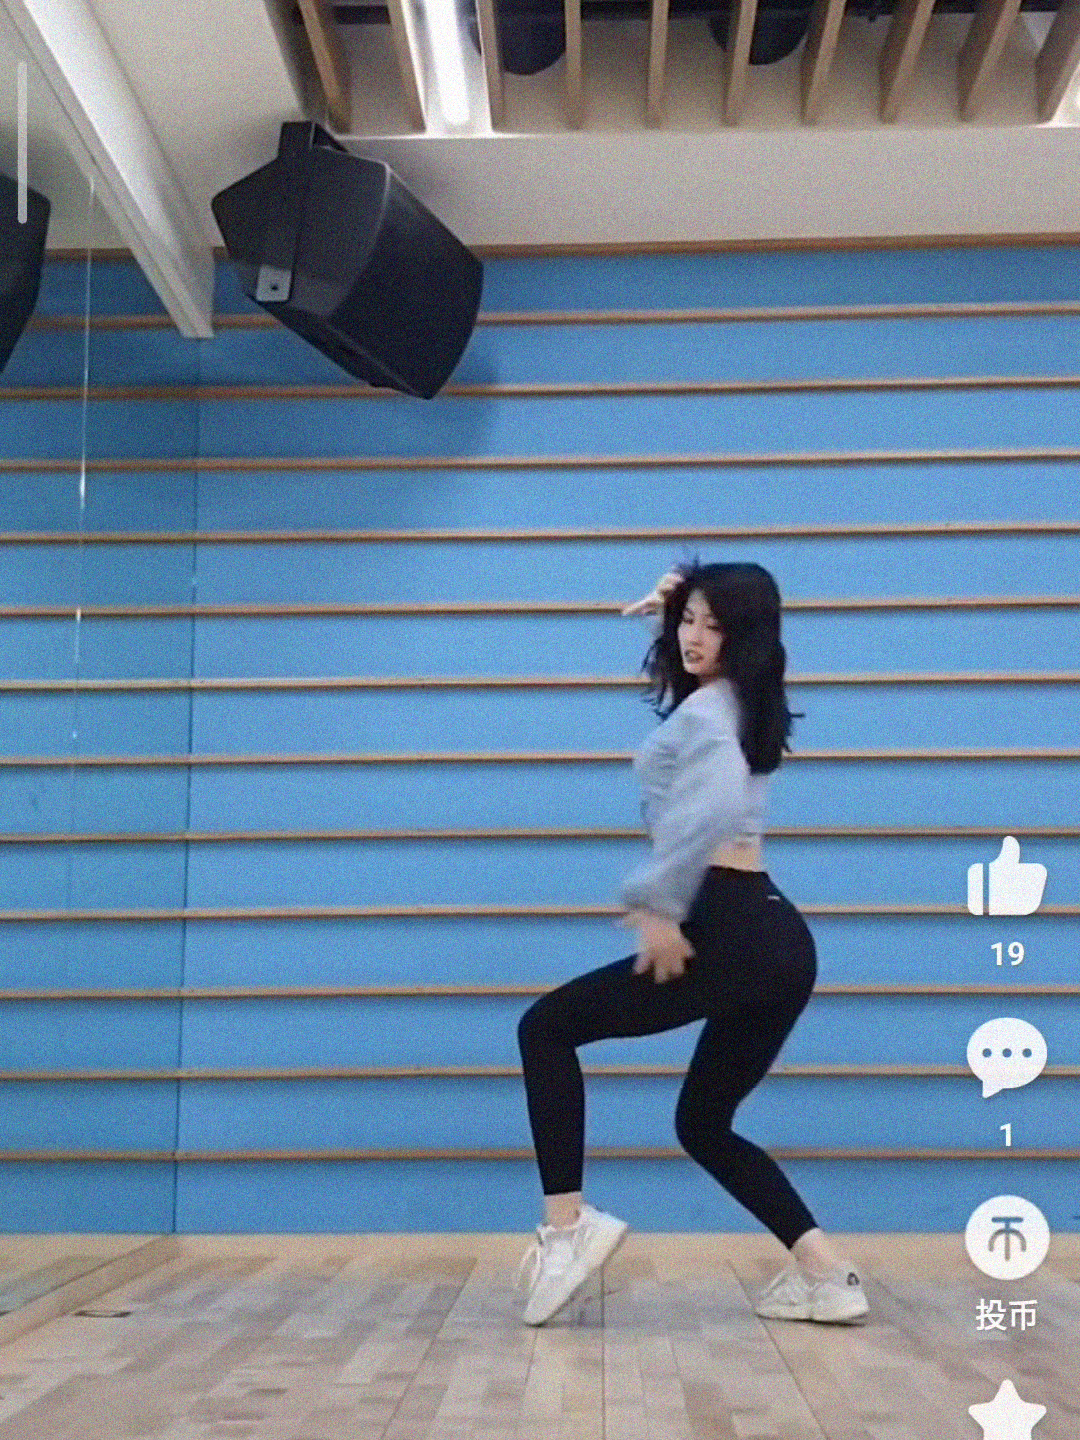

In [100]:
transform3 = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1, 0.5), # adding noise to see how the ft works
    transforms.ToPILImage()
])

transform3(img)

In [101]:
def gaussian_kernel(m, n, std):
    gaussian_m = signal.gaussian(m, std)
    gaussian_n = signal.gaussian(n, std)
    gaussian2D = np.outer(gaussian_m, gaussian_n)
    return torch.from_numpy(gaussian2D)

def ft_bandpass_filter(img, low=0.1, high=0.4):
    m, n = img.shape
    low = low * min(m, n)
    high = high * min(m, n)
    ft = torch.fft.fft2(img)
    ft_shift = torch.fft.fftshift(ft)
    ft_shift_abs = torch.abs(ft_shift)
    ft_shift_phase = torch.angle(ft_shift) 
    
    # filtering
    # low is the lowest frequency allowed -> bound of high-pass filter
    # high is the highest frequency allowed -> bound of low-pass filter
    low_pass_f = gaussian_kernel(m, n, high)
    if low == 0:
        high_pass_f = torch.ones_like(low_pass_f)
    else:
        high_pass_f = 1 - gaussian_kernel(m, n, low)
    band_pass_f = torch.multiply(low_pass_f, high_pass_f) 
    ft_shift_abs = torch.multiply(ft_shift_abs, band_pass_f) 
    
    # rebuild image
    z = torch.multiply (ft_shift_abs , torch.exp((1j)*(ft_shift_phase)))
    ift_shift = torch.fft.ifftshift(z)
    filt_img = torch.fft.ifft2(ift_shift)
    filt_img = torch.abs(filt_img).clip(0, 1)
        
    return filt_img

def f3_ft(img):
    red_channel = ft_bandpass_filter(img[0, :, :], low=0, high=0.2)
    green_channel = ft_bandpass_filter(img[1, :, :], low=0, high=0.2)
    blue_channel = ft_bandpass_filter(img[2, :, :], low=0, high=0.2)
    return torch.stack([red_channel,
                       green_channel, 
                       blue_channel]).float()

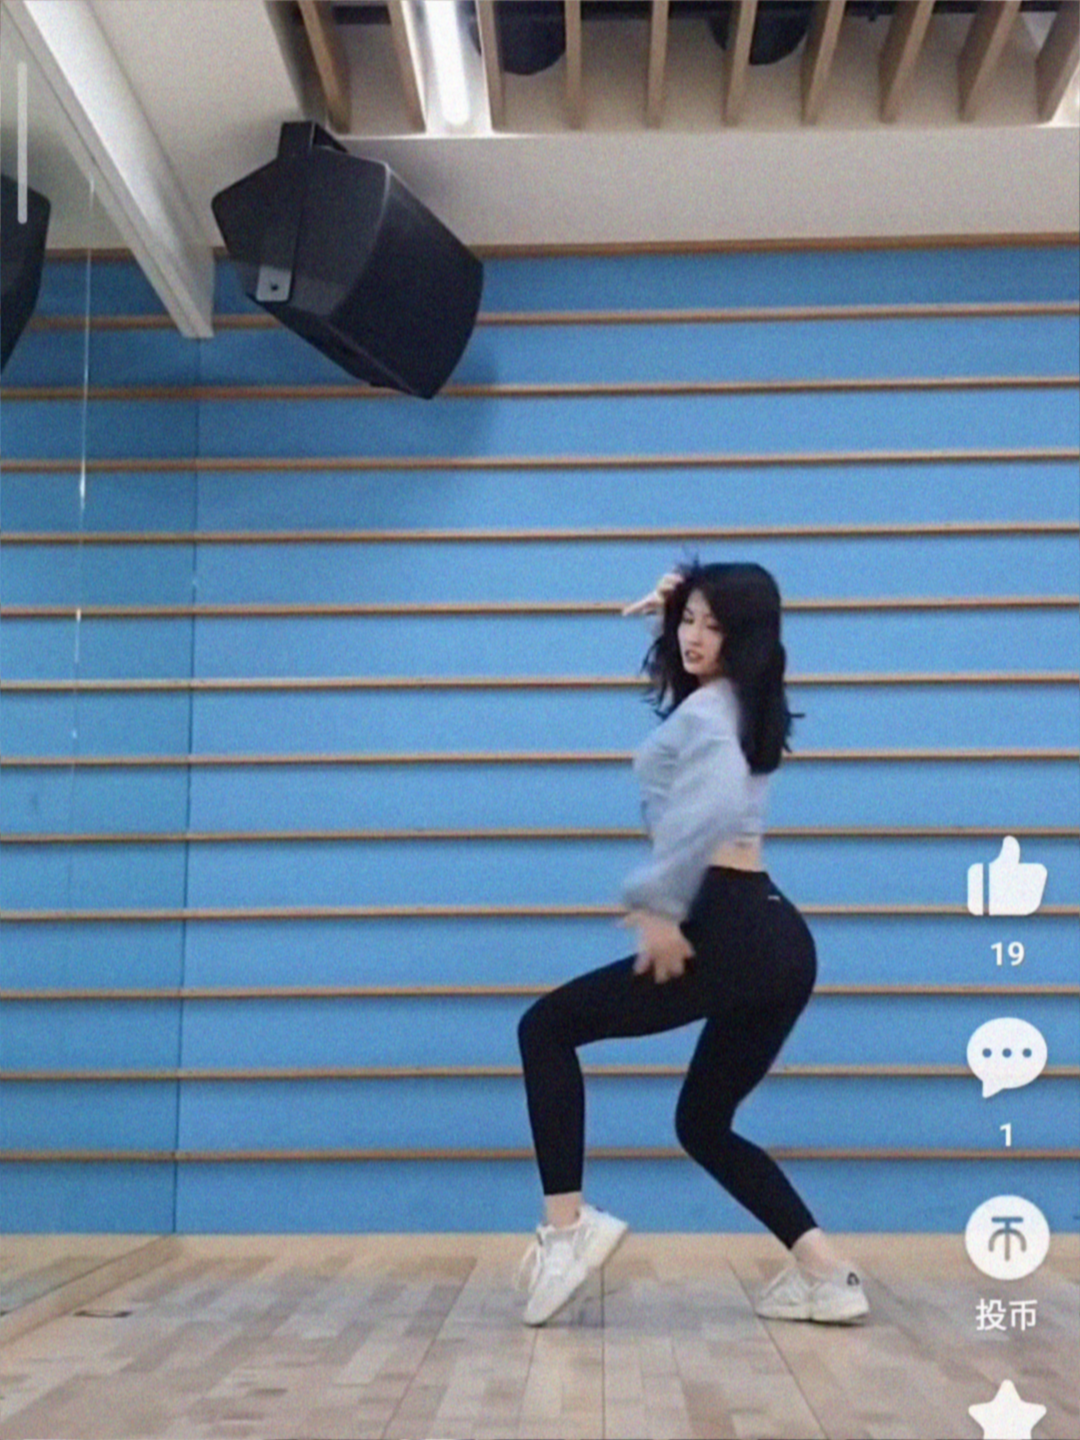

In [102]:
transform3 = transforms.Compose([
    # transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1, 0.5), # adding noise to see how the ft works
    transforms.Lambda(f3_ft),
    # transforms.Normalize((0.5, 0.5, 0.5), 
    #                      (0.5, 0.5, 0.5)),
    transforms.ToPILImage()
])

transform3(img)

**TRAINING**

In [103]:
batch_size = 20
classes = ('normal', 'carrying', 'threat')
num_of_labels = len(classes)

# normalize data using transformers
transform3 = transforms.Compose([
    transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Lambda(f3_ft),
    transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5)),
])

# train
train_set3 = CS4243_dataset(root, train_df, transform = transform3)
train_loader3 = DataLoader(train_set3, batch_size=batch_size, shuffle = True, drop_last=True)
print("The number of images in a training set is: ", len(train_loader3)*batch_size)

# test
test_set3 = CS4243_dataset(root, test_df, transform=transform3)
test_loader3 = DataLoader(test_set3, batch_size=batch_size, shuffle=False, drop_last=True)
print("The number of images in a test set is: ", len(test_loader3)*batch_size)

print("The number of batches per epoch is: ", len(train_loader3))

The number of images in a training set is:  720
The number of images in a test set is:  80
The number of batches per epoch is:  36


In [104]:
model3_path = "./model3.pth" ## CHANGE ##
output3_path = "./test_out3.pth" ## CHANGE ##

[1,    10] loss: 0.105
[1,    20] loss: 0.099
[1,    30] loss: 0.097
[2,    10] loss: 0.097
[2,    20] loss: 0.098
[2,    30] loss: 0.097
[3,    10] loss: 0.093
[3,    20] loss: 0.097
[3,    30] loss: 0.095
[4,    10] loss: 0.095
[4,    20] loss: 0.090
[4,    30] loss: 0.092
[5,    10] loss: 0.088
[5,    20] loss: 0.094
[5,    30] loss: 0.092
Training finished in 3.683333333333333 minutes.
Model saved in  ./model3.pth
[6.090312659740448, 5.660597741603851, 5.7258241176605225, 5.401587605476379, 4.895215570926666]


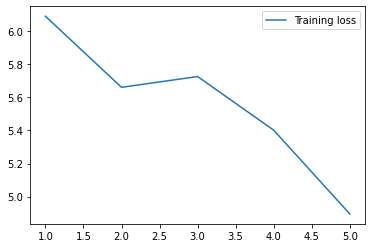

In [105]:
model3 = Network3(num_of_labels, dropout).to(device)
_, losses3 = train(model3, train_loader3, loss_fn(), 
                   optimizer(model3.parameters(), **optim_params), epoch, device, model3_path)
plt.plot(list(range(1, epoch + 1)), losses3, label='Training loss')
plt.legend()
plt.show()

Testing finished. Model saved in  ./test_out3.pth
normal accuracy: 39/45 = 86.67%
carrying accuracy: 3/26 = 11.54%
threat accuracy: 3/9 = 33.33%
Overall accuracy: 45/80 = 56.25%


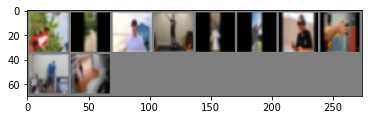

target:  ['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal']
predicted:  ['carrying', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal']


In [106]:
test(model3, test_loader3, output3_path, device, classes)
show_test_accuracy(output3_path, root, transform3, show=10)

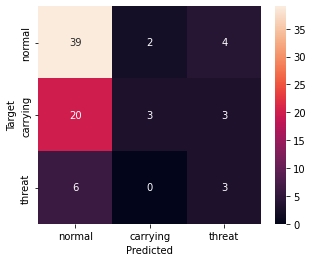

In [107]:
cm3 = plotConfusionMatrix(output3_path, classes)

In [108]:
generateClassificationReport(output3_path, classes)

              precision    recall  f1-score   support

      normal       0.60      0.12      0.19        26
    carrying       0.60      0.87      0.71        45
      threat       0.30      0.33      0.32         9

    accuracy                           0.56        80
   macro avg       0.50      0.44      0.41        80
weighted avg       0.57      0.56      0.50        80



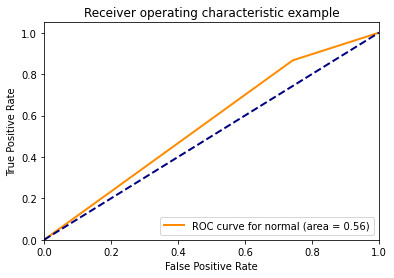

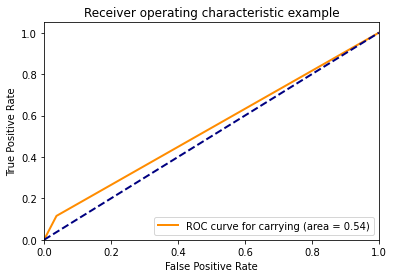

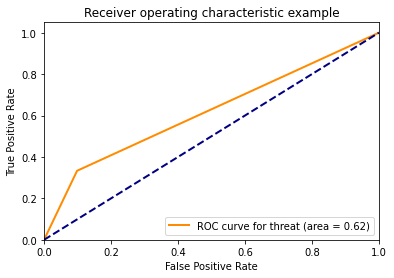

In [109]:
plotROC(output3_path, classes)

## **NETWORK 4**

In [75]:
loss_fn = nn.CrossEntropyLoss
optimizer = Adam
optim_params = {'lr':0.001, 'weight_decay':0.0001}
epoch = 10
dropout = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else (
    "mps" if torch.backends.mps.is_available() else "cpu"))

In [76]:
def gaussian_kernel(m, n, std):
    gaussian_m = signal.gaussian(m, std)
    gaussian_n = signal.gaussian(n, std)
    gaussian2D = np.outer(gaussian_m, gaussian_n)
    return torch.from_numpy(gaussian2D)

def ft_bandpass_filter(img, low=0.1, high=0.4):
    m, n = img.shape
    low = low * min(m, n)
    high = high * min(m, n)
    ft = torch.fft.fft2(img)
    ft_shift = torch.fft.fftshift(ft)
    ft_shift_abs = torch.abs(ft_shift)
    ft_shift_phase = torch.angle(ft_shift) 
    
    # filtering
    # low is the lowest frequency allowed -> bound of high-pass filter
    # high is the highest frequency allowed -> bound of low-pass filter
    low_pass_f = gaussian_kernel(m, n, high)
    if low == 0:
        high_pass_f = torch.ones_like(low_pass_f)
    else:
        high_pass_f = 1 - gaussian_kernel(m, n, low)
    band_pass_f = torch.multiply(low_pass_f, high_pass_f) 
    ft_shift_abs = torch.multiply(ft_shift_abs, band_pass_f) 
    
    # rebuild image
    z = torch.multiply (ft_shift_abs , torch.exp((1j)*(ft_shift_phase)))
    ift_shift = torch.fft.ifftshift(z)
    filt_img = torch.fft.ifft2(ift_shift)
    filt_img = torch.abs(filt_img).clip(0, 1)
        
    return filt_img

In [77]:
def f4(img):
    channels = []
    bands = [0, 0.2, 0.5, 0.8, 1]
    for i in range(1, len(bands)):
        channels.append(ft_bandpass_filter(img[0, :, :], low=bands[i-1], high=bands[i]))
        channels.append(ft_bandpass_filter(img[1, :, :], low=bands[i-1], high=bands[i]))
        channels.append(ft_bandpass_filter(img[2, :, :], low=bands[i-1], high=bands[i]))
    
    return torch.stack(channels).float()

In [78]:
batch_size = 20
classes = ('normal', 'carrying', 'threat')
num_of_labels = len(classes)

# normalize data using transformers
transform4 = transforms.Compose([
    transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Lambda(f4),
    transforms.Normalize((0.5, ) * 12, 
                         (0.5, ) * 12),
])

# train
train_set4 = CS4243_dataset(root, train_df, transform=transform4)
train_loader4 = DataLoader(train_set4, batch_size=batch_size, shuffle=True, drop_last=True)
print("The number of images in a training set is: ", len(train_loader4)*batch_size)

# test
test_set4 = CS4243_dataset(root, test_df, transform=transform4)
test_loader4 = DataLoader(test_set4, batch_size=batch_size, shuffle=False, drop_last=True)
print("The number of images in a test set is: ", len(test_loader4)*batch_size)

print("The number of batches per epoch is: ", len(train_loader4))

The number of images in a training set is:  720
The number of images in a test set is:  80
The number of batches per epoch is:  36


In [79]:
model4_path = "./model4.pth" ## CHANGE ##
output4_path = "./test_out4.pth" ## CHANGE ##

[1,    10] loss: 0.105
[1,    20] loss: 0.103
[1,    30] loss: 0.104
[2,    10] loss: 0.103
[2,    20] loss: 0.098
[2,    30] loss: 0.102
[3,    10] loss: 0.100
[3,    20] loss: 0.096
[3,    30] loss: 0.099
[4,    10] loss: 0.098
[4,    20] loss: 0.098
[4,    30] loss: 0.095
[5,    10] loss: 0.100
[5,    20] loss: 0.096
[5,    30] loss: 0.098
Training finished in 3.85 minutes.
Model saved in  ./model4.pth
[5.510163724422455, 5.508454322814941, 5.99590790271759, 6.203626096248627, 5.758544147014618]


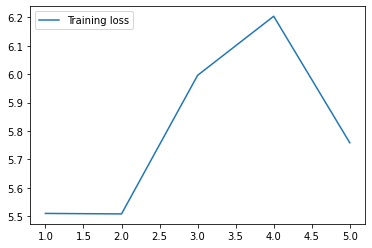

In [80]:
model4 = Network4(num_of_labels, dropout).to(device)
_, losses4 = train(model4, train_loader4, loss_fn(), 
                   optimizer(model4.parameters(), **optim_params), epoch, device, model4_path)
plt.plot(list(range(1, epoch + 1)), losses4, label='Training loss')
plt.legend()
plt.show()

Testing finished. Model saved in  ./test_out4.pth
normal accuracy: 45/45 = 100.00%
carrying accuracy: 0/26 = 0.00%
threat accuracy: 0/9 = 0.00%
Overall accuracy: 45/80 = 56.25%


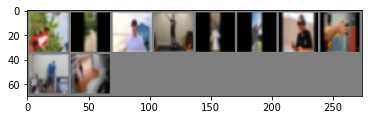

target:  ['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal']
predicted:  ['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal']


In [81]:
test(model4, test_loader4, output4_path, device, classes)
show_test_accuracy(output4_path, root, transform4, show=10)

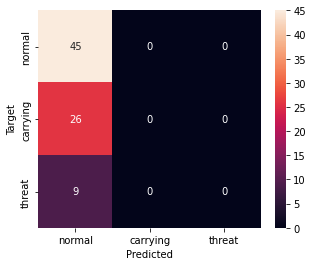

In [82]:
cm4 = plotConfusionMatrix(output4_path, classes)

In [83]:
generateClassificationReport(output4_path, classes)

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        26
    carrying       0.56      1.00      0.72        45
      threat       0.00      0.00      0.00         9

    accuracy                           0.56        80
   macro avg       0.19      0.33      0.24        80
weighted avg       0.32      0.56      0.40        80



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


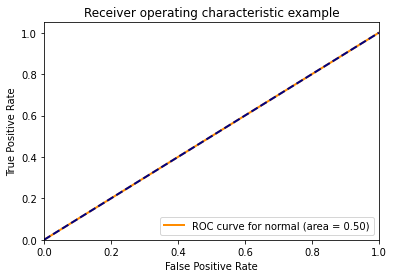

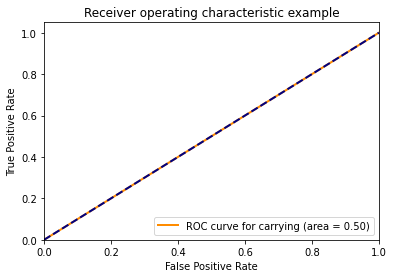

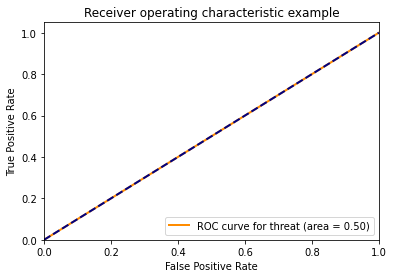

In [84]:
plotROC(output4_path, classes)